In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

main_experiments_path = "../experiments"
housing_experiment_path = "../../15_incremental_rbf_housing/experiments"

main_experiments = []


method_names = [
    "svr",
    "pls",
    "gradboost",
    "mlp_0.01",
    "mlp_0.001",
    "mlp_0.0001",
    "rbf_full_0.01",
    "rbf_full_0.001",
    "rbf_full_0.0001",
    "rbf_diag_0.01",
    "rbf_diag_0.001",
    "rbf_diag_0.0001",
    "rbf_scal_0.01",
    "rbf_scal_0.001",
    "rbf_scal_0.0001",
    "rbf_univ_0.01",
    "rbf_univ_0.001",
    "rbf_univ_0.0001",
    "ffn_0.1_0.01",
    "ffn_0.1_0.001",
    "ffn_0.1_0.0001",
    "ffn_1_0.01",
    "ffn_1_0.001",
    "ffn_1_0.0001",
    "ffn_10_0.01",
    "ffn_10_0.001",
    "ffn_10_0.0001",
    "uffn_0.1_0.01",
    "uffn_0.1_0.001",
    "uffn_0.1_0.0001",
    "uffn_1_0.01",
    "uffn_1_0.001",
    "uffn_1_0.0001",
    "uffn_10_0.01",
    "uffn_10_0.001",
    "uffn_10_0.0001",
]


condensed_method_names = [
    "svr",
    "pls",
    "gradboost",
    "mlp",
    "rbf_full",
    "rbf_diag",
    "rbf_scal",
    "rbf_univ",
    "ffn",
    "uffn",
]



experiments_df = pd.DataFrame()


method_settings = os.listdir(main_experiments_path)

# sort by name

method_settings = sorted(method_settings)

#print all folders in the main experiments path
for method_setting in method_settings:
    #print(method_setting)
    # iterate over repetitions

    experiment_df = pd.DataFrame()

    if method_setting.startswith("."):
        continue

    for repetition in os.listdir(main_experiments_path + "/" + method_setting):
        #print(repetition)
        # iterate over files

        if repetition.startswith("."):
            continue

        ## add this repetition to the experiment df as column
        experiment_df[repetition] = None

        dataset_folders = os.listdir(main_experiments_path + "/" + method_setting + "/" + repetition)

        ## sort the dataset folders by name
        dataset_folders = sorted(dataset_folders)

        for dataset in dataset_folders:
            
            if "data" in dataset and dataset != "data":
                #print(dataset)

                ## add this dataset to the experiment df as row if it is not already there
                if dataset not in experiment_df.index:
                    experiment_df.loc[dataset] = None

                try:
                    ## read the npy file
                    train_loss = np.load(main_experiments_path + "/" + method_setting + "/" + repetition + "/" + dataset+ "/" + "train_loss.npy")
                    val_loss = np.load(main_experiments_path + "/" + method_setting + "/" + repetition + "/" + dataset + "/" + "val_loss.npy")
                    test_loss = np.load(main_experiments_path + "/" + method_setting + "/" + repetition + "/" + dataset + "/" + "test_loss.npy")
                except Exception as e:
                    print("Error reading files for dataset: ", dataset, e)
                    continue
                
                # if "rabe" in dataset:
                #     ### plot the val loss
                #     plt.title(dataset + " " + method_setting + " " + repetition)
                #     plt.plot(val_loss)
                #     plt.ylim(0, 100)
                #     plt.show()
                
                ### extract the min val loss and pick the corresponding test loss

                min_val_loss = np.min(val_loss)
                min_val_loss_index = np.argmin(val_loss)

                min_test_loss = test_loss[min_val_loss_index]

            
                ## add the test loss to the experiment df
                experiment_df.loc[dataset, repetition] = min_test_loss

    ## order by dataset name
    experiment_df = experiment_df.sort_index()

    ## add a column which represents the mean of all repetitions
    experiment_df["mean"] = experiment_df.mean(axis=1)

    ## set mean to nan if there are any nans in the row
    experiment_df.loc[experiment_df.isnull().any(axis=1), "mean"] = np.nan

    ## add the experiment df to the experiments df
    experiments_df[method_setting] = experiment_df["mean"]


housing_experiments_df = pd.DataFrame()

method_settings = os.listdir(housing_experiment_path)

# exclude folders beginning with . (e.g. .DS_Store)
method_settings = [method_setting for method_setting in method_settings if not method_setting.startswith(".")]

# sort by name
method_settings = sorted(method_settings)

#print all folders in the main experiments path
for method_setting in method_settings:
    #print(method_setting)
    # iterate over repetitions

    experiment_df = pd.DataFrame()

    print("method_setting: ", method_setting)

    if method_setting.startswith("."):
        continue

    for repetition in os.listdir(housing_experiment_path + "/" + method_setting):

        ## exclude folders beginning with . (e.g. .DS_Store)
        if repetition.startswith("."):
            continue

        #print(repetition)
        # iterate over files

        ## add this repetition to the experiment df as column
        experiment_df[repetition] = None

        dataset_folders = os.listdir(housing_experiment_path + "/" + method_setting + "/" + repetition)

        ## sort the dataset folders by name
        dataset_folders = sorted(dataset_folders)

        dataset = "data"
        dataset_name = "housing"

        ## add this dataset to the experiment df as row if it is not already there
        if dataset_name not in experiment_df.index:
            experiment_df.loc[dataset_name] = None

        try:
            ## read the npy file
            train_loss = np.load(housing_experiment_path + "/" + method_setting + "/" + repetition + "/" + dataset+ "/" + "train_loss.npy")
            val_loss = np.load(housing_experiment_path + "/" + method_setting + "/" + repetition + "/" + dataset + "/" + "val_loss.npy")
            test_loss = np.load(housing_experiment_path + "/" + method_setting + "/" + repetition + "/" + dataset + "/" + "test_loss.npy")
        except Exception as e:
            print("Error reading files for dataset: ", dataset_name, e)
            continue

        ### extract the min val loss and pick the corresponding test loss
        min_val_loss = np.min(val_loss)
        min_val_loss_index = np.argmin(val_loss)

        min_test_loss = test_loss[min_val_loss_index]

        print("Min Val Loss: ", min_val_loss)
        #print("Corresponding Test Loss: ", min_test_loss)

        ## add the test loss to the experiment df
        experiment_df.loc[dataset_name, repetition] = min_test_loss

    ## order by dataset name
    experiment_df = experiment_df.sort_index()

    ## add a column which represents the mean of all repetitions
    experiment_df["mean"] = experiment_df.mean(axis=1)

    print(experiment_df)

    ## set mean to nan if there are any nans in the row
    experiment_df.loc[experiment_df.isnull().any(axis=1), "mean"] = np.nan

    #print(experiment_df)

    ## add the experiment df to the experiments df as a new row
    housing_experiments_df[method_setting] = experiment_df["mean"]


## add the housing experiments to the main experiments


#experiments_df = pd.concat([experiments_df, housing_experiments_df])


for i in range(36):
    ## rename column experiment_000001 to method_names[0]
    exp_name = "experiment_" + str(i+1).zfill(6)
    experiments_df = experiments_df.rename(columns={exp_name: method_names[i]})

experiments_df




method_setting:  experiment_000001
Min Val Loss:  0.018772798729287773
Min Val Loss:  0.01857373138296632
Min Val Loss:  0.01763609629105418
Min Val Loss:  0.01741520022103032
Min Val Loss:  0.01827570458778178
Min Val Loss:  0.017938964580040243
Min Val Loss:  0.016721072347327684
Min Val Loss:  0.018319915026364007
         repetition_000003 repetition_000004 repetition_000005  \
housing           0.019126          0.018678          0.017719   

        repetition_000002 repetition_000007 repetition_000000  \
housing          0.019583          0.018337          0.019342   

        repetition_000001 repetition_000006      mean  
housing          0.018081          0.019023  0.018736  
method_setting:  experiment_000002
Min Val Loss:  0.16614148104162407
Min Val Loss:  0.5712449167556447
Min Val Loss:  0.02235572662860703
Min Val Loss:  0.023885267784945964
Min Val Loss:  0.12555094989946083
Min Val Loss:  0.022421281966754646
Min Val Loss:  0.024925884422590392
Min Val Loss:  0.575082

,svr,pls,gradboost,mlp_0.01,mlp_0.001,mlp_0.0001,rbf_full_0.01,rbf_full_0.001,rbf_full_0.0001,rbf_diag_0.01,...,ffn_10_0.0001,uffn_0.1_0.01,uffn_0.1_0.001,uffn_0.1_0.0001,uffn_1_0.01,uffn_1_0.001,uffn_1_0.0001,uffn_10_0.01,uffn_10_0.001,uffn_10_0.0001
data1027_ESL,0.320432,0.278913,0.326697,0.29944,0.286591,0.319761,0.287665,0.277898,0.297948,0.287665,...,1.757245,0.334051,0.328103,0.321261,0.345064,0.333148,0.363901,0.350873,0.3452,0.367245
data1029_LEV,0.381405,0.374298,0.39391,0.742987,0.76657,0.733002,0.749678,0.756572,0.773082,0.749678,...,0.888599,0.7527,0.741605,0.752932,0.754394,0.745508,0.747372,0.764743,0.748426,0.750934
data1030_ERA,2.699722,2.604035,2.739899,5.550449,5.260922,5.147094,5.383059,5.199917,5.17009,5.382229,...,5.560544,5.473438,5.484914,5.30597,5.593852,5.589485,5.468314,5.558434,5.592979,5.476598
data1096_FacultySalaries,18.710392,17.627326,7.04294,4.06058,3.920137,6.221893,4.910444,5.892262,30.818562,4.910444,...,73.816048,22.063682,21.399009,87.215762,39.904187,40.813622,75.144621,32.10213,32.059858,57.726641
data192_vineyard,8.827151,8.470092,11.354858,9.686404,11.389782,10.49085,21.731634,47.411502,50.913809,21.731634,...,26.341039,11.150625,10.441978,35.921777,20.210673,15.462407,23.586502,23.305768,19.027985,26.681209
data210_cloud,0.336284,0.177004,0.244064,0.204087,0.209195,0.359146,0.265449,0.232837,0.615073,0.265449,...,1.219592,0.245269,0.246294,0.346308,0.705194,0.736426,0.660103,1.182809,1.168696,1.132452
data228_elusage,476.174357,155.709501,208.615905,156.340895,292.215763,1312.225685,146.745843,519.635926,908.46004,146.745843,...,924.952171,348.720135,305.958605,743.094236,389.50576,414.038036,879.273932,453.328777,475.650042,788.337189
data485_analcatdata_vehicle,79195.818875,37845.363209,30202.318622,39391.197021,33732.469482,112002.211914,33989.830566,43443.800293,110168.319336,33989.830566,...,122731.587891,34139.318604,51440.114502,137757.234375,29706.377441,34460.734863,124541.033691,40829.815796,37692.062988,125818.899902
data519_vinnie,3.717933,2.302786,2.658418,2.378981,2.307067,2.306566,3.396398,5.087037,7.309411,3.396398,...,8.198725,2.575035,2.564066,3.963347,3.078672,3.097396,5.490694,3.819674,3.51758,7.748572
data523_analcatdata_neavote,3.898526,1.186272,1.884856,1.162559,1.20895,11.823594,1.132315,6.077915,20.522427,1.132315,...,3.512053,1.2179,1.292753,7.695047,1.051596,1.077313,4.265165,0.924725,0.962323,4.133799


In [2]:
condensed_experiments_df = pd.DataFrame()
## iterate over the condensed method names and pick the min test loss for the corresponding methods 
for condensed_method in condensed_method_names:
    condensed_experiments_df[condensed_method] = experiments_df[[method for method in method_names if method.startswith(condensed_method)]].min(axis=1)

## set all None to nan
condensed_experiments_df = condensed_experiments_df.replace({None: np.nan})

condensed_experiments_df


,svr,pls,gradboost,mlp,rbf_full,rbf_diag,rbf_scal,rbf_univ,ffn,uffn
data1027_ESL,3.204317e-01,2.789132e-01,3.266970e-01,2.865910e-01,2.778983e-01,2.778983e-01,2.735390e-01,3.114449e-01,3.689075e-01,3.212610e-01
data1029_LEV,3.814046e-01,3.742979e-01,3.939099e-01,7.330018e-01,7.496783e-01,7.496783e-01,7.461485e-01,7.516051e-01,8.120926e-01,7.416049e-01
data1030_ERA,2.699722e+00,2.604035e+00,2.739899e+00,5.147094e+00,5.170090e+00,5.170090e+00,5.234076e+00,5.375882e+00,5.512194e+00,5.305970e+00
data1096_FacultySalaries,1.871039e+01,1.762733e+01,7.042940e+00,3.920137e+00,4.910444e+00,4.910444e+00,4.806959e+00,4.613198e+00,3.956116e+01,2.139901e+01
data192_vineyard,8.827151e+00,8.470092e+00,1.135486e+01,9.686404e+00,2.173163e+01,2.173163e+01,2.184604e+01,7.839786e+00,9.578493e+00,1.044198e+01
data210_cloud,3.362837e-01,1.770042e-01,2.440637e-01,2.040868e-01,2.328371e-01,2.328371e-01,2.454178e-01,2.205685e-01,4.699558e-01,2.452695e-01
data228_elusage,4.761744e+02,1.557095e+02,2.086159e+02,1.563409e+02,1.467458e+02,1.467458e+02,1.754424e+02,1.354383e+02,6.126126e+02,3.059586e+02
data485_analcatdata_vehicle,7.919582e+04,3.784536e+04,3.020232e+04,3.373247e+04,3.398983e+04,3.398983e+04,5.219488e+04,3.448178e+04,4.035557e+04,2.970638e+04
data519_vinnie,3.717933e+00,2.302786e+00,2.658418e+00,2.306566e+00,3.396398e+00,3.396398e+00,3.347151e+00,2.372581e+00,2.799129e+00,2.564066e+00
data523_analcatdata_neavote,3.898526e+00,1.186272e+00,1.884856e+00,1.162559e+00,1.132315e+00,1.132315e+00,1.178541e+00,1.170005e+00,1.357908e+00,9.247249e-01


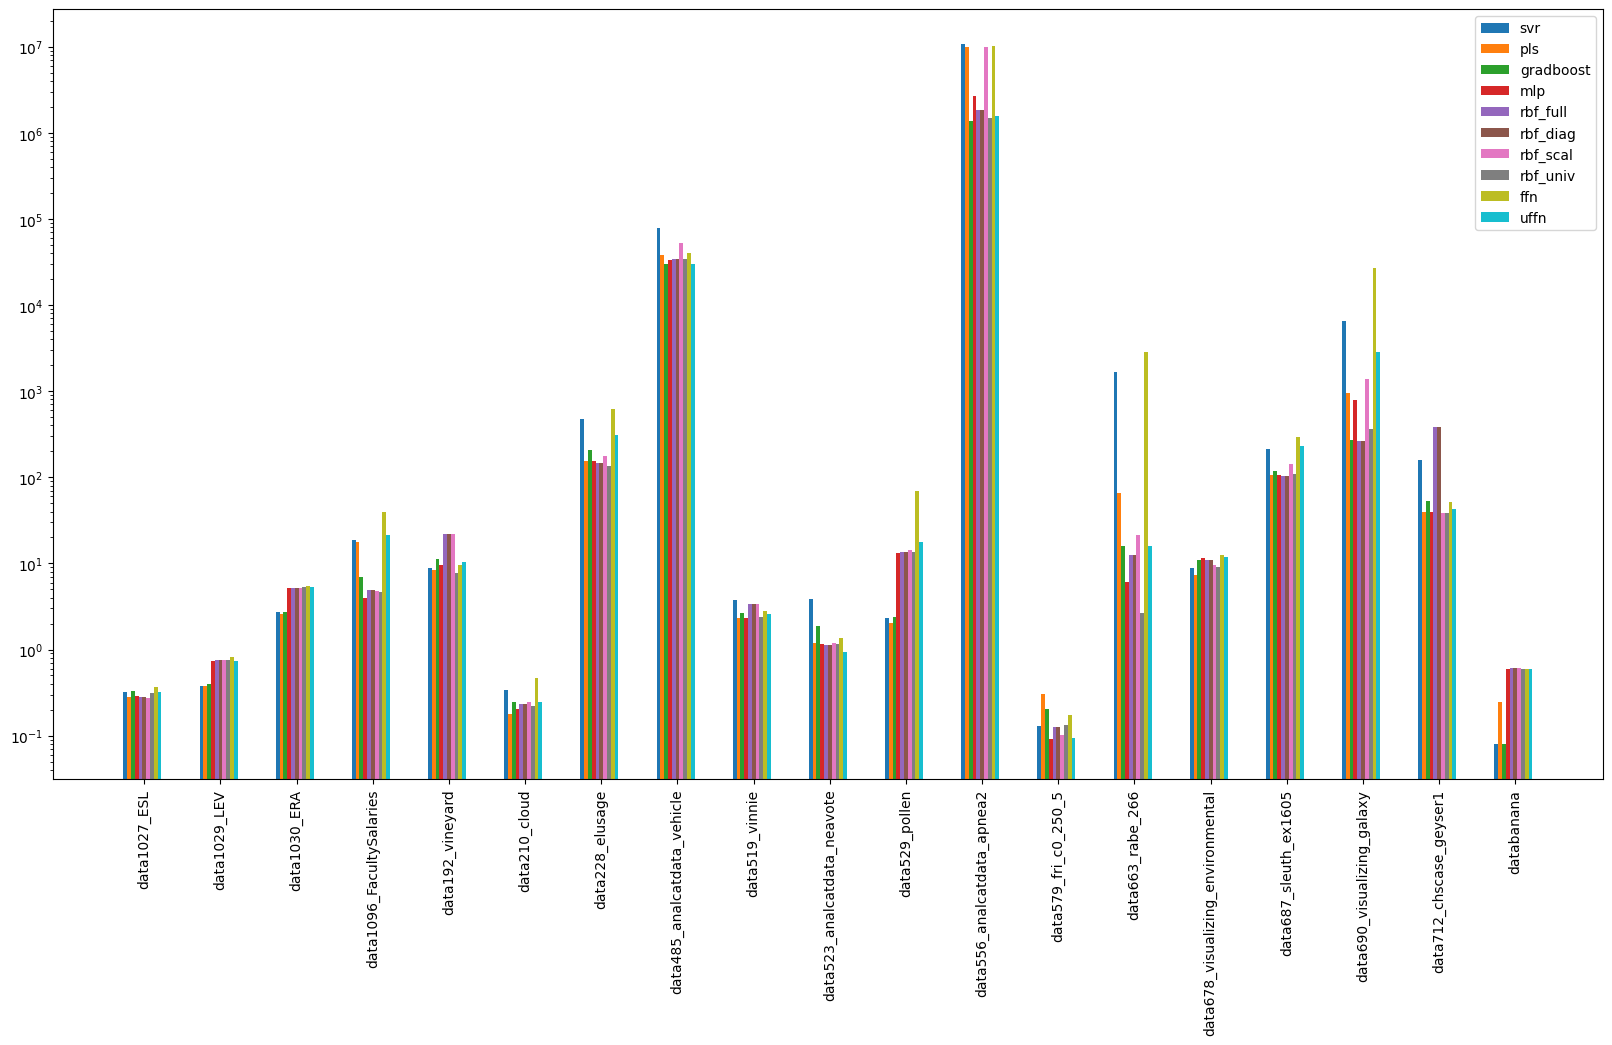

In [3]:
## visualize the results using matplotlib using a log scale and multiple bars per dataset 

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

bar_width = 0.05
x = np.arange(len(condensed_experiments_df.index))

for i, method in enumerate(condensed_experiments_df.columns):
    plt.bar(x + i*bar_width, condensed_experiments_df[method], width=bar_width, label=method)

plt.xticks(x + (len(condensed_experiments_df.columns)/2)*bar_width, condensed_experiments_df.index, rotation=90)

plt.yscale("log")
plt.legend(condensed_experiments_df.columns)
plt.show()



In [4]:
### normalize the results by the mlp result for each dataset

normalized_experiments_df = condensed_experiments_df.copy()

for dataset in normalized_experiments_df.index:
    mlp_result = normalized_experiments_df.loc[dataset, "mlp"]
    #normalized_experiments_df.loc[dataset] = normalized_experiments_df.loc[dataset] / mlp_result



/var/folders/vx/2hn3fq3j01ndcrt24ck57sr80000gn/T/ipykernel_34771/2143758889.py:30: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10e5)


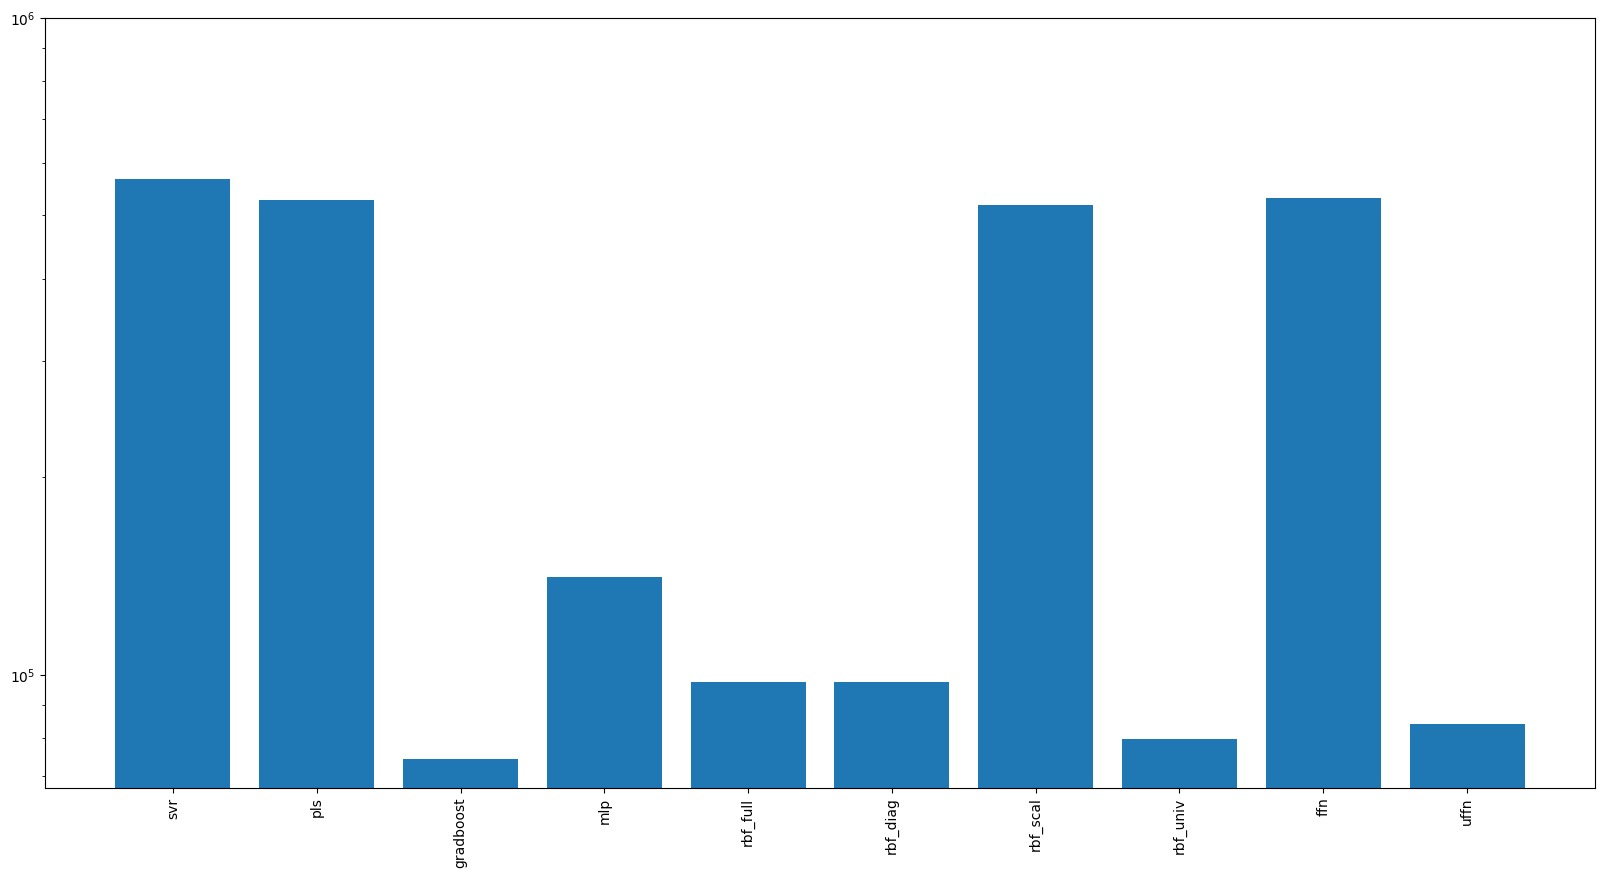

In [5]:
### calculate an average across all datasets for each method and visualize the results

average_across_datasets = normalized_experiments_df.mean(axis=0)


method_renaming = {
    "svr": "SVR",
    #"pls": "PLS",
    "gradboost": "GradBoost",
    "mlp": "MLP",
    #"rbf_full": "RBF Full",
    "rbf_diag": "RBF",
    #"rbf_scal": "RBF Scal",
    "rbf_univ": "U-RBF",
    "ffn": "FFM",
    "uffn": "U-FFM",
}

## rename the methods and exclude methods whose names are not in the method_renaming dict

#average_across_datasets = average_across_datasets[average_across_datasets.index.isin(method_renaming.keys())]
#average_across_datasets = average_across_datasets.rename(index=method_renaming)


plt.figure(figsize=(20,10))
plt.bar(average_across_datasets.index, average_across_datasets)
plt.xticks(rotation=90)

plt.yscale("log")
plt.ylim(0, 10e5)

plt.show()




In [6]:
import torch

out_features = 3
in_features = 2
b = 4

x = torch.randn(b,in_features)

steps = torch.zeros(in_features) + 2

vars = torch.nn.Parameter(((torch.zeros(out_features,in_features,in_features) + 1 + torch.eye(in_features) * steps)).inverse())


print(vars)
print(vars.pow(2))

means = torch.rand(in_features, out_features)


x = x.unsqueeze(-1).repeat(1,1,out_features)

x = (x - means[None,:,:]).transpose(1,2)

#print(x.shape)
#print(vars.shape)

x = x.unsqueeze(-2) @ (vars.pow(2))[None,:,:,:] @ x.unsqueeze(-1)

x = torch.exp(-0.5 * x)

print(x.shape)



Parameter containing:
tensor([[[ 0.3750, -0.1250],
         [-0.1250,  0.3750]],

        [[ 0.3750, -0.1250],
         [-0.1250,  0.3750]],

        [[ 0.3750, -0.1250],
         [-0.1250,  0.3750]]], requires_grad=True)
tensor([[[0.1406, 0.0156],
         [0.0156, 0.1406]],

        [[0.1406, 0.0156],
         [0.0156, 0.1406]],

        [[0.1406, 0.0156],
         [0.0156, 0.1406]]], grad_fn=<PowBackward0>)
torch.Size([4, 3, 1, 1])
